In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Toggle code on/off in a notebook

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

**Motivation**

Gait is the locomotion caused by limb movement, defined as bipedal, biphasic forward propulsion of the center of gravity of the human body using the arms and legs. Although most humans walk (or run) using a similar process, there are differences in limb movement patterns that can characterize an individual’s gait. Gait is affected by many factors such as pathology, age,
height, and gender.

Thus, the biomechanics of gait are complicated with numerous parameters that vary from person to person and should allow quantitative association of a gait with a human identity. If a person’s motion characteristics can be typified, gait can be employed as a method of identity verification for various security measures such as building entrances and bank/ATM
transactions.

**Data Acquisition**

Using the Empatica E4 wristband with a three-axis accelerometer, I tracked 3-D acceleration data in a group of walkers. By training a classifier on gait data, I successfully (80% accuracy) associated walkers with their correct gaits based on variations inherent in gait. Further related questions of interest include

 - Does knowledge of the walker’s gender improve the classifier’s accuracy or speed? What about age?
 - Does the speed of walking impact the identifiability of gait?
 - Do the walker’s hands have to be freely swinging in order to categorize gait? For example, if someone is holding their credit    card up as they walk up to an ATM, will they still be recognizable?
 
For my data acquisition, I asked five participants (including myself) to walk normally for four ~30 second time periods while wearing the Empatica Band on their dominiant wrist. From that data collection, I reserved three samples from each participant for my training set - 15 samples in total. The remaining samples I reserved for later to test the classification of the model.

**Methodology**

For each of the six participants, I found their signature gait by averaging all three of their training samples and plotted it as a visual representation of the personalization of gait. I then created a three-item feature vector for each sample containing 1) the sample's largest frequency component, 2) the sample's second largest frequency component, and 3) the participant's sex. 

I chose these particular feature vectors because in my preliminary data analysis and research, I found that medical data and previous attempts at the gait identification problem provided good support for the significance of these particular attributes in gait. For frequencies, I was inspired by the approach taken in "A Frequency Domain Approach to Silhouette based
Gait Recognition", an engineering paper that proposed Fourier Transform as a method to prepare gait data for classification. In my own preliminary data analysis, I found that the Fast Fourier Transforms of different participant's gait samples did in fact look different, so I decided to use the largest two of these components as feature vectors. As for gender, much of the population variability in human gait can be attributed to the gross physical differences between men and women. Men tend to be taller, with longer limbs, and therefore larger strides than women. For ease of computation, I represented gender as a binary variable - 1 for females, 0 for males. 

Throughout my data analysis, I experimented with other features such as pace, principal components, and height; however, frequency components and gender yielded the best results with the fewest features. To avoid overfitting, I restricted by feature vectors to a length of three with possible five classes.

I chose LDA as my classifier because it can find a good predictor for the identity (i.e. a class) of any gait sample of the same distribution (not necessarily from the training set) given only that one observation. If I assume that the conditional PDFs are normally distributed with distinct mean and covariance parameters, then I can use Bayes rule to predict a gait as being from *x* class if the log of the likelihood ratios is below some threshold. For this, I used scikit-learn's LinearDiscriminantAnalysis function.

For each subject, I plotted the magnitude of their signature gait and calculated the class mean and covariance matrix using a feature vector computed for that signature gait.

**Preparation of Training Data**

In [3]:
# load acceleration datasets and initialize variables
trainingSetAcc = np.array(["ACC_UNA.csv", "ACC_JES.csv", "ACC_DDP.csv", "ACC_ENN.csv", "ACC_TJR.csv"])
trainingSetSignatures = []
acc, magACC, tACC = [], [], []

for i in range(len(trainingSetAcc)):
    acc.append(pd.read_csv(trainingSetAcc[i], header=0, sep=',').values)
    magACC.append(np.sqrt(np.square(acc[i][1:,:]).sum(axis=1)))
    tACC.append(np.linspace(1,60, len(acc[i][1::, 0].astype(float))))

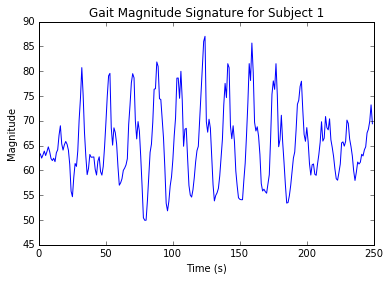

Class 1's mean feature vector is  [  1.63408322e+04   1.08219154e+03   1.00000000e+00]
Class 1's covariance matrix is 
[[ 82854404.84674031  82674353.85114488  82898039.96673968]
 [ 82674353.85114488  82510451.90855977  82751736.35634416]
 [ 82898039.96673968  82751736.35634416  83014379.29508111]]


In [4]:
# extract three samples from Participant 1
UA_example_0 = magACC[0][400:650]
UA_example_1 = magACC[0][850:1100]
UA_example_2 = magACC[0][1150:1450]

# compile samples, normalizing their length to the length of the shortest sample
UA_examples = np.array([UA_example_0[0:250], UA_example_1[0:250], UA_example_2[0:250]])
t_acc = range(0, 250)

# define mean gait
UA_signature = np.mean(UA_examples, axis=0)

# plot mean gait
plt.plot(range(250), UA_signature)
plt.title("Gait Magnitude Signature for Subject 1")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

# create (hopefully) unique feature vectors with first two FFT components and gender
UA_features = np.zeros([3, 3])
for i in range(len(UA_examples)):
    UA_features[i] = np.array([sorted(abs(np.fft.fft(UA_examples[i])), reverse=True)[0], sorted(abs(np.fft.fft(UA_examples[i])), reverse=True)[1], 1])
    
UA_cov = np.cov(UA_features)
UA_mean = np.array([sorted(abs(np.fft.fft(UA_signature)), reverse=True)[0], sorted(abs(np.fft.fft(UA_signature)), reverse=True)[1], 1])

print "Class 1's mean feature vector is ", UA_mean
print "Class 1's covariance matrix is "
print UA_cov

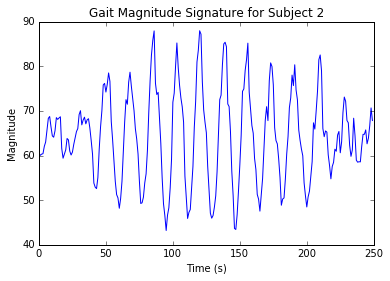

Class 2's mean feature vector is  [  1.60935268e+04   1.46517041e+03   1.00000000e+00]
Class 2's covariance matrix is 
[[ 77990314.24228774  77802590.71839702  77998267.64784923]
 [ 77802590.71839702  77616889.00083578  77812299.47981167]
 [ 77998267.64784923  77812299.47981167  78008227.56014372]]


In [5]:
# extract three samples from Participant 2
JS_example_0 = magACC[1][300:550]
JS_example_1 = magACC[1][650:925]
JS_example_2 = magACC[1][975:1275]

# compile samples, normalizing their length to the length of the shortest sample
JS_examples = np.array([JS_example_0[0:250], JS_example_1[0:250], JS_example_2[0:250]])
t_acc = range(0, 250)

# define mean gait
JS_signature = np.mean(JS_examples, axis=0)
    
# plot mean gait
plt.plot(range(250), JS_signature)
plt.title("Gait Magnitude Signature for Subject 2")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

# create (hopefully) unique feature vectors with first two FFT components and gender
JS_features = np.zeros([3, 3])
for i in range(len(JS_examples)):
    JS_features[i] = np.array([sorted(abs(np.fft.fft(JS_examples[i])), reverse=True)[0], sorted(abs(np.fft.fft(JS_examples[i])), reverse=True)[1], 0])
    
JS_cov = np.cov(JS_features)
JS_mean = np.array([sorted(abs(np.fft.fft(JS_signature)), reverse=True)[0], sorted(abs(np.fft.fft(JS_signature)), reverse=True)[1], 1])

print "Class 2's mean feature vector is ", JS_mean
print "Class 2's covariance matrix is "
print JS_cov

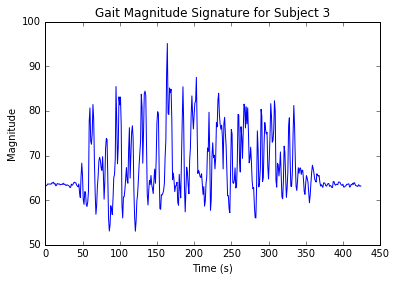

Class 3's mean feature vector is  [  2.86527311e+04   7.94743579e+02   1.00000000e+00]
Class 3's covariance matrix is 
[[  2.52533939e+08   2.61321033e+08   2.51939201e+08]
 [  2.61321033e+08   2.70511186e+08   2.60714593e+08]
 [  2.51939201e+08   2.60714593e+08   2.51346694e+08]]


In [6]:
# extract three samples from Participant 3
DP_example_0 = magACC[2][100:550]
DP_example_1 = magACC[2][725:1150]
DP_example_2 = magACC[2][1305:1750]

# compile samples, normalizing their length to the length of the shortest sample
DP_examples = np.array([DP_example_0[0:425], DP_example_1[0:425], DP_example_2[0:425]])
t_acc = range(0, 425)

# define mean gait
DP_signature = np.mean(DP_examples, axis=0)

# plot mean gait
plt.plot(range(425), DP_signature)
plt.title("Gait Magnitude Signature for Subject 3")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

# create (hopefully) unique feature vector with first two FFT components and gender
DP_features = np.zeros([3, 3])
for i in range(len(DP_examples)):
    DP_features[i] = np.array([sorted(abs(np.fft.fft(DP_examples[i])), reverse=True)[0], sorted(abs(np.fft.fft(DP_examples[i])), reverse=True)[1], 1])
    
DP_cov = np.cov(DP_features)
DP_mean = np.array([sorted(abs(np.fft.fft(DP_signature)), reverse=True)[0], sorted(abs(np.fft.fft(DP_signature)), reverse=True)[1], 1])

print "Class 3's mean feature vector is ", DP_mean
print "Class 3's covariance matrix is "
print DP_cov

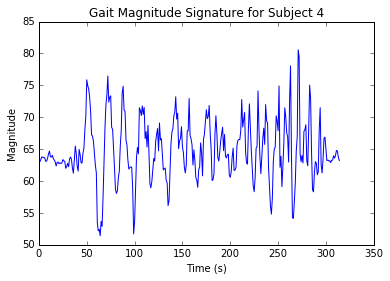

Class 4's mean feature vector is  [  2.04268041e+04   3.92881524e+02   1.00000000e+00]
Class 4's covariance matrix is 
[[  1.29230928e+08   1.30208099e+08   1.30661907e+08]
 [  1.30208099e+08   1.31194540e+08   1.31651933e+08]
 [  1.30661907e+08   1.31651933e+08   1.32110932e+08]]


In [7]:
# extract three samples from Participant 4
EN_example_0 = magACC[3][225:560]
EN_example_1 = magACC[3][650:985]
EN_example_2 = magACC[3][985:1300]

# compile samples, normalizing their length to the length of the shortest sample
EN_examples = np.array([EN_example_0[0:315], EN_example_1[0:315], EN_example_2[0:315]])
t_acc = range(0, 315) 

# define mean gait
EN_signature = np.mean(EN_examples, axis=0)

# plot mean gait
plt.plot(range(315), EN_signature)
plt.title("Gait Magnitude Signature for Subject 4")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

# create (hopefully) unique feature vectors with first two FFT components and gender
EN_features = np.zeros([3, 3])
for i in range(len(EN_examples)):
    EN_features[i] = np.array([sorted(abs(np.fft.fft(EN_examples[i])), reverse=True)[0], sorted(abs(np.fft.fft(EN_examples[i])), reverse=True)[1], 1])
    
EN_cov = np.cov(EN_features)
EN_mean = np.array([sorted(abs(np.fft.fft(EN_signature)), reverse=True)[0], sorted(abs(np.fft.fft(EN_signature)), reverse=True)[1], 1])

print "Class 4's mean feature vector is ", EN_mean
print "Class 4's covariance matrix is "
print EN_cov

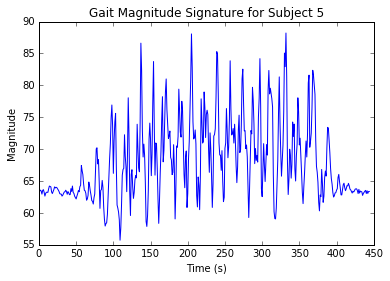

Class 5's mean feature vector is  [  3.03068993e+04   1.02906022e+03   1.00000000e+00]
Class 5's covariance matrix is 
[[  2.93026199e+08   2.95672569e+08   2.91172483e+08]
 [  2.95672569e+08   2.98343210e+08   2.93802085e+08]
 [  2.91172483e+08   2.93802085e+08   2.89330496e+08]]


In [8]:
# extract three samples from Participant 5
TR_example_0 = magACC[4][850:1295]
TR_example_1 = magACC[4][1425:1875]
TR_example_2 = magACC[4][2000:2460]

# compile samples, normalizing their length to the length of the shortest sample
TR_examples = np.array([TR_example_0[0:445], TR_example_1[0:445], TR_example_2[0:445]])
t_acc = range(0, 445) 

# define mean gait
TR_signature = np.mean(TR_examples, axis=0)

# plot mean gait
plt.plot(range(445), TR_signature)
plt.title("Gait Magnitude Signature for Subject 5")
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

# create (hopefully) unique feature vectors with first two FFT components and gender
TR_features = np.zeros([3, 3])
for i in range(len(TR_examples)):
    TR_features[i] = np.array([sorted(abs(np.fft.fft(TR_examples[i])), reverse=True)[0], sorted(abs(np.fft.fft(TR_examples[i])), reverse=True)[1], 1])
    
TR_cov = np.cov(TR_features)
TR_mean = np.array([sorted(abs(np.fft.fft(TR_signature)), reverse=True)[0], sorted(abs(np.fft.fft(TR_signature)), reverse=True)[1], 1])

print "Class 5's mean feature vector is ", TR_mean
print "Class 5's covariance matrix is "
print TR_cov

**Preparation of Testing Data**

In [9]:
# extract one gait sample from each participant
UA_example_3 = magACC[0][1600:1900] 
JS_example_3 = magACC[1][1350:1625] 
DP_example_3 = magACC[2][1900:2350] 
EN_example_3 = magACC[3][1325::]
TR_example_3 = magACC[4][2650::]

# compile one test sample from each participant
testingSet = [UA_example_3[0:250], JS_example_3[0:250], DP_example_3[0:425], EN_example_3[0:315], TR_example_3[0:445]]

# create (hopefully) unique feature vectors with first two FFT components and gender
testingSetFeatures = np.zeros([5, 3])
for i, j in zip(range(len(testingSet)), [1, 0, 1, 1]):
    testingSetFeatures[i] = np.array([sorted(abs(np.fft.fft(testingSet[i])), reverse=True)[0], sorted(abs(np.fft.fft(testingSet[i])), reverse=True)[1], j])

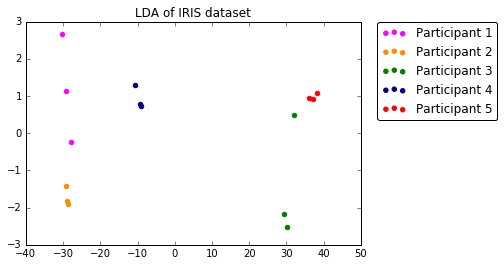

The accuracy of this gait recognition algorithm is  80.0 %


In [10]:
# compile samples from all participants
samples = np.vstack((UA_features, JS_features, DP_features, EN_features, TR_features))

# create labels for each sample (number refers to "class" aka participant identity)
y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])
participants = ["Participant 1", "Participant 2", "Participant 3", "Participant 4", "Participant 5"]

# train LDA on 18 gait samples
clf = LinearDiscriminantAnalysis(n_components=4)
clf.fit(samples, y)
new = clf.transform(samples)

# plot clusters of gait samples
plt.figure()
for color, i, target_name in zip(['magenta', 'darkorange', 'green', 'navy', 'red'], np.array([0, 1, 2, 3, 4]), participants):
    plt.scatter(new[y == i, 0], new[y == i, 1], color=color, label=target_name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fancybox=True)
plt.title('LDA of IRIS dataset')
plt.show()

# test model on with test sample set to determine accuracy
hits, misses = 0, 0 

for i in range(len(testingSetFeatures)):
    if clf.predict(testingSetFeatures[i]) == i:
        hits += 1.

print "The accuracy of this gait recognition algorithm is ", hits/len(testingSetFeatures)*100, "%"

**Challenge: The Emcumbered Walker**

To further test my model, I sought to complicate my classification by adding a realistic restriciton on my data - recording gait data while participants were encumbered. Wearing the Empatica band on their dominant hand, 5 participants walked while holding a cell phone in front of them for 30 secs (to simulate a common occupation of the hands during locomotion). Theoretically, this should make the classification problem more difficult by eliminating the information derived from hand motion. 

To classify these, I tested them just as I did above with my testing set samples, and as I hypothesized, the model performs worse on these samples - achieving only 33.3% accuracy.

In [11]:
encumberedTestingSet = np.array(["ACC_UA.csv", "ACC_JS.csv", "ACC_DP.csv"])
acc, magACC, tACC = [], [], []

for i in range(len(encumberedTestingSet)):
    acc.append(pd.read_csv(encumberedTestingSet[i], header=0, sep=',').values)
    magACC.append(np.sqrt(np.square(acc[i][1:,:]).sum(axis=1)))
    tACC.append(np.linspace(1,60, len(acc[i][1::, 0].astype(float))))

# compile one test sample from each participant
UA_encumbered = magACC[0][1700:2065] - np.mean(magACC[0][1700:2065])
JS_encumbered = magACC[1][1625:-50] - np.mean(magACC[1][1625:-50])
DP_encumbered = magACC[2][1225:1560] - np.mean(magACC[2][1225:1560])

encumberedTestingSet = [DP_encumbered, JS_encumbered, UA_encumbered]

# create (hopefully) unique feature vectors with first two FFT components and gender
testingSetFeatures = np.zeros([3, 3])
for i, j in zip(range(len(encumberedTestingSet)), [1, 0, 1]):
    testingSetFeatures[i] = np.array([sorted(abs(np.fft.fft(encumberedTestingSet[i])), reverse=True)[0], sorted(abs(np.fft.fft(encumberedTestingSet[i])), reverse=True)[1], j])
    
# test model on with test sample set to determine accuracy
hits, misses = 0, 0 

for i in range(len(testingSetFeatures)):
    if clf.predict(testingSetFeatures[i]) == i:
        hits += 1.

print "The accuracy of this gait recognition algorithm is ", hits/len(testingSetFeatures)*100, "%"

The accuracy of this gait recognition algorithm is  33.3333333333 %


**References**

Sengupta, Soumyadip, Udit Halder, Rameswar Panda, and Ananda S. Chowdhury. A Frequency Domain Approach to Silhouette Based Gait Recognition. ADepartment of Electronics and Tele-Communication Engineering, Jadavpur University, Kolkata, India, n.d. Web. 20 Nov. 2016.

"Human Gait." Wikipedia. Wikimedia Foundation, n.d. Web. 02 Nov. 2016. 

Gender differences in three dimensional gait analysis data from 98 healthy Korean adults. Cho, S.H. et al. Clinical Biomechanics , Volume 19 , Issue 2 , 145 - 152